# Digit Recognition with Unsigned Integer Values
- This is a replication of the digit recognition program but this time using the actual `uint8` data types for the feature space.
- The thing about binary MNIST is that there is not enough information in the vanila encoding of `vsa_digit_recog.ipynb`. However, in this version we use VSA while incoporating more info by the values of the pixels. Let us see if it works well.

In [ ]:
# Parameters
import os
import sys
import numpy as np

# Path directories
curr_dir = os.getcwd()
lib_path = curr_dir + "/../../lib"
extract_path = curr_dir + "/../../extract_data"
data_path = curr_dir + "/../../data"
dir_bin_data = data_path + "/mnist_uint"

# Appending other paths for libraries
sys.path.append(lib_path)
sys.path.append(extract_path)

import vsa
import figs
from extract_data_util import download_and_extract, split_data, read_data, convert_binning_quantization

## Data Extraction

In [ ]:
url = "https://github.com/rgantonio/chronomatica/releases/download/mnist_dataset_v1.0/chronomatica_mnist_uint.tar.gz"

download_and_extract(
    url=url,
    out_dir=data_path,
    delete_archive=True,
)

# Set class list
class_list = [0,1,2,3,4,5,6,7,8,9]

# Read data
X_data = read_data(class_list, dir_bin_data)

# Train and test split
train_test_split = 0.6
train_valid_split = 0.75

X_train_set, X_test_set = split_data(X_data, class_list, split_percent=0.6)
X_train_set_src, X_valid_set = split_data(X_train_set, class_list, split_percent=0.75)

## VSA Model
- In this VSA model, what changes is that each feature element (i.e., each pixel) is multiplied to a randomly generated hypervector from the item memory. Then they are summed up together.
- Mathematically we have:

$$ \mathcal{hv}_{\textrm{enc}} = \sum_{i=0}^{N_{\textrm{feat}}=784} \mathcal{hv}_{\textrm{pixel}}[i] \times X[i] $$

- Where $X[i]$ is the feature scalar value.
- We will find out if flattening the result with some binarization matters in here.

In [ ]:
class digitVSA(vsa.ModelVSA):
    def encode(self, item_data):
        # Feature length
        item_len = len(item_data)
        # Threshold for binarization
        threshold = item_len // 2
        # Encode hypervector
        encoded_vec = item_data @ self.ortho_im[0:item_len]
        # Binarization
        if self.binarize_encode:
            encoded_vec = vsa.binarize_hv(encoded_vec, threshold, self.hv_type)
        return encoded_vec

# Training, Retraining, and Testing
- This time we add a switch to collect the accuracies in a list varying the HV dimensions

In [12]:
# Parameters
hv_dim_set = [512, 1024, 2048, 4096, 8192]
hv_dim_set_len = len(hv_dim_set)
accuracy_list = np.zeros(hv_dim_set_len)

- The run below takes an hour to run, so we just get the initial measures, clear the simulation run to avoid bloating the log.

In [ ]:
for hv_dim in hv_dim_set:
    # Create the VSA model with target parameters
    digit_model = digitVSA(
        hv_size = hv_dim,
        class_list = class_list,
    )

    # Train the model
    digit_model.train_model(X_train_set_src)

    # Retraining the model
    digit_model.retrain_model(X_valid_set)

    # Test the model
    digit_model.test_model(X_test_set)

    # Save accuracy
    accuracy_list[hv_dim_set.index(hv_dim)] = digit_model.model_accuracy

for i in range(len(accuracy_list)):
    accuracy_list[i] = accuracy_list[i]*100

accuracy_list

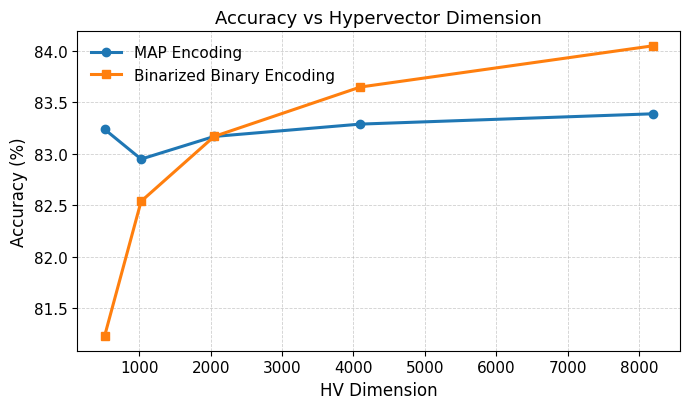

In [13]:
acc = [
    [83.24, 82.95, 83.17, 83.29, 83.39],
    [81.23, 82.54, 83.17, 83.65, 84.05],
]

hv_dim = [512, 1024, 2048, 4096, 8192]

legend = ['MAP Encoding', 'Binarized Binary Encoding']
x_label = 'HV Dimension'
y_label = 'Accuracy (%)'
title = 'Accuracy vs Hypervector Dimension'

figs.multiLinePlot(
    x_data=hv_dim,
    y_data_list=acc,
    legend_list=legend,
    x_label=x_label,
    y_label=y_label,
    title=title,
).plot_fig()

## Alternative Bipolar Encoding
- An alternative way which is the classic VSA/HDC method is to encode the continuous (or integer) values into bipoler hypervectors too such that:

$$ \mathcal{hv}_{\textrm{enc}} = \sum_{i=0}^{N_{\textrm{feat}}=784} \mathcal{hv}_{\textrm{pixel}}[i] \otimes \mathcal{hv}_{\textrm{pixel-val}}[i] $$

- Where $\mathcal{hv}_{\textrm{pixel-val}}[i]$ is the hypervector pixel value.
- However, take note that we need a continuous item memory (CiM) to do so where the consecutive values of the CiM have some significant similarity in between that is also in a continuous form. Checkout more aobut the CiM.
- Before we proceed we need to re-load the training and testing data to have the appropriate values.

In [11]:
# Convering feature levels from 0-255 to 0-cim_levels
# Change this accordingly
cim_levels = 16
max_level = 255

X_train_set_src_conv = convert_binning_quantization(X_train_set_src, max_level, cim_levels)
X_valid_set_conv = convert_binning_quantization(X_valid_set, max_level, cim_levels)
X_test_set_conv = convert_binning_quantization(X_test_set, max_level, cim_levels)

- Here, we need to make a new class model for this case:

In [ ]:
class digitBindVSA(vsa.ModelVSA):
    def encode(self, item_data):
        # Feature length
        item_len = len(item_data)
        # Threshold for binarization
        threshold = item_len // 2
        # Encode hypervector
        encoded_vec = np.zeros(self.hv_size,dtype=int)
        for i in range(item_len):
            encoded_vec += vsa.hv_mult(self.ortho_im[i], self.cim[item_data[i]])
        # Binarization
        if self.binarize_encode:
            encoded_vec = vsa.binarize_hv(encoded_vec, threshold, self.hv_type)
        return encoded_vec

In [ ]:
for hv_dim in hv_dim_set:
    # Create the VSA model with target parameters
    digit_model = digitBindVSA(
        hv_size = hv_dim,
        class_list = class_list,
        num_cim = num_cim,
    )

    # Train the model
    digit_model.train_model(X_train_set_src_conv)

    # Retraining the model
    digit_model.retrain_model(X_valid_set_conv)

    # Test the model
    digit_model.test_model(X_test_set_conv)

    # Save accuracy
    accuracy_list[hv_dim_set.index(hv_dim)] = digit_model.model_accuracy

for i in range(len(accuracy_list)):
    accuracy_list[i] = accuracy_list[i]*100

accuracy_list

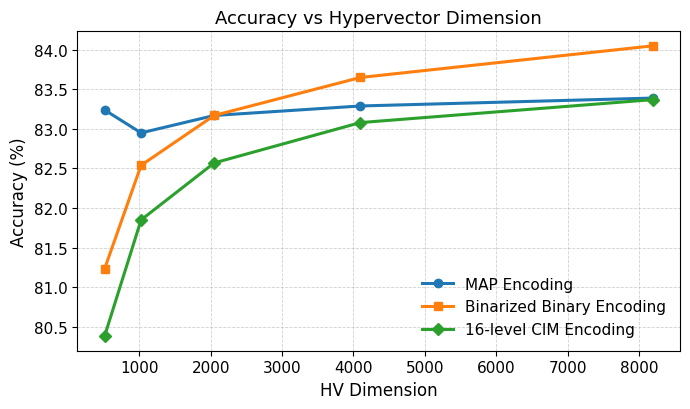

In [14]:
acc = [
    [83.24, 82.95, 83.17, 83.29, 83.39],
    [81.23, 82.54, 83.17, 83.65, 84.05],
    [80.38, 81.85, 82.57, 83.08, 83.37],
]

legend = ['MAP Encoding', 'Binarized Binary Encoding', '16-level CIM Encoding']

figs.multiLinePlot(
    x_data=hv_dim,
    y_data_list=acc,
    legend_list=legend,
    x_label=x_label,
    y_label=y_label,
    title=title,
).plot_fig()

- What the above data shows is that a normal binarized binary encoding will still be better maybe because the features are much simpler (i.e., binary numbers)
- However, between MAP encoding and the CIM, the MAP gives much better accuracy.
- **Conclusion: It is preferrable to use MAP encoding with actual values and without having to encode values into the HV space**

## Varying CIM Levels
- It is interesting to know how we can vary CIM levels instead and figure out how much of the CiM levels can actually help.

In [ ]:

num_cim_list = [4, 8, 16, 32, 64]
hv_dim = 1024

for cim_levels in num_cim_list:

    X_train_set_src_conv = convert_binning_quantization(X_train_set_src, max_level, cim_levels)
    X_valid_set_conv = convert_binning_quantization(X_valid_set, max_level, cim_levels)
    X_test_set_conv = convert_binning_quantization(X_test_set, max_level, cim_levels)

    # Create the VSA model with target parameters
    digit_model = digitBindVSA(
        hv_size = hv_dim,
        class_list = class_list,
        num_cim = cim_levels,
    )

    # Train the model
    digit_model.train_model(X_train_set_src_conv)

    # Retraining the model
    digit_model.retrain_model(X_valid_set_conv)

    # Test the model
    digit_model.test_model(X_test_set_conv)

    # Save accuracy
    accuracy_list[num_cim_list.index(cim_levels)] = digit_model.model_accuracy

for i in range(len(accuracy_list)):
    accuracy_list[i] = accuracy_list[i]*100

accuracy_list

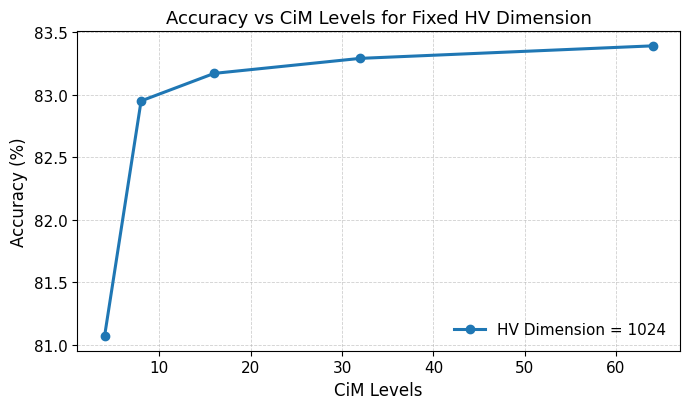

In [9]:
acc = [
    [81.07, 82.95, 83.17, 83.29, 83.39],
]

num_cim_list = [4, 8, 16, 32, 64]
hv_dim = 1024


legend = ['HV Dimension = 1024']
x_label = 'CiM Levels'
y_label = 'Accuracy (%)'
title = 'Accuracy vs CiM Levels for Fixed HV Dimension'

figs.multiLinePlot(
    x_data=num_cim_list,
    y_data_list=acc,
    legend_list=legend,
    x_label=x_label,
    y_label=y_label,
    title=title,
).plot_fig()

- In the above figure, having different levels for the MNIST application does not give too much of a change. Moving from like 81% to 83.4% isn't a big jump.
- Although the technique exists it may not work for this application.

## Conclusions
- So far, we can only conclude that Using MAP where we stick to the features is still a much more powerful representation than using CiM levels.